<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia


Estimated time needed: **40** minutes


In this lab, you will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled `List of Falcon 9 and Falcon Heavy launches`

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/Falcon9_rocket_family.svg)


Falcon 9 first stage will land successfully


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


More specifically, the launch records are stored in a HTML table shown below:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


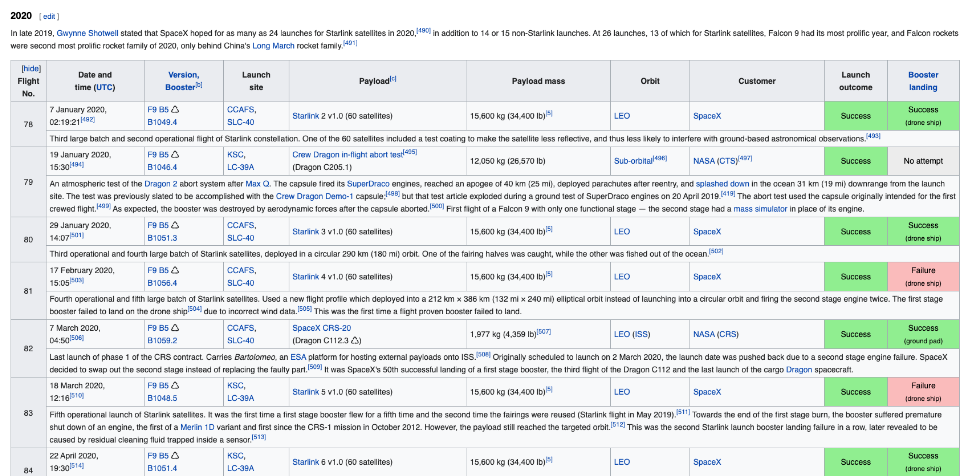  ## Objectives
Web scrap Falcon 9 launch records with `BeautifulSoup`: 
- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame


First let's import required packages for this lab


In [1]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

and we will provide some helper functions for you to process web scraped HTML table


In [4]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`


In [3]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

Next, request the HTML page from the above URL and get a `response` object


### TASK 1: Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.


In [4]:
import requests

# Definir la URL estática para la snapshot de Wikipedia
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

# Enviar una solicitud GET a la URL estática
response = requests.get(static_url)

# Verificar el código de estado de la respuesta
print(response.status_code)  # Debería imprimir 200 si la solicitud fue exitosa

200


Create a `BeautifulSoup` object from the HTML `response`


In [8]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
# Analizar el contenido HTML de la página
soup = BeautifulSoup(response.content, 'html.parser')

Print the page title to verify if the `BeautifulSoup` object was created properly 


In [11]:
# Use soup.title attribute
page_title = soup.title.string
print("Título de la página:", page_title)


Título de la página: List of Falcon 9 and Falcon Heavy launches - Wikipedia


### TASK 2: Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header


Let's try to find all tables on the wiki page first. If you need to refresh your memory about `BeautifulSoup`, please check the external reference link towards the end of this lab


In [13]:
# Find all tables on the wiki page
tables = soup.find_all('table', {'class': 'wikitable'})

# Verify how many tables were found
print(f"Found {len(tables)} tables on the page.")

# Access the third table which contains the launch records
target_table = tables[2]

# Extract the header row
header_row = target_table.find('tr')

# Get the text of each header cell, strip whitespace, and store in a list
column_names = [header.get_text(strip=True) for header in header_row.find_all('th')]

# Print the column names
print("Column names:", column_names)

Found 13 tables on the page.
Column names: ['Flight No.', 'Date andtime (UTC)', 'Version,Booster[b]', 'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer', 'Launchoutcome', 'Boosterlanding']


Starting from the third table is our target table contains the actual launch records.


In [14]:
# Acceder a la tercera tabla que contiene los registros de lanzamiento
target_table = tables[2]

# Extraer el encabezado de la tabla
headers = target_table.find_all('th')

# Obtener los nombres de las columnas
column_names = [header.get_text(strip=True) for header in headers]

# Imprimir los nombres de las columnas
print("Nombres de las columnas:", column_names)

Nombres de las columnas: ['Flight No.', 'Date andtime (UTC)', 'Version,Booster[b]', 'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer', 'Launchoutcome', 'Boosterlanding', '14', '15', '16', '17', '18', '19', '20']


You should able to see the columns names embedded in the table header elements `<th>` as follows:


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```


Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one


In [17]:
# Find the target table
tables = soup.find_all('table', {'class': 'wikitable'})
target_table = tables[2]

# Extract the header row
header_row = target_table.find('tr')

# Extract column names using the provided function
column_names = [extract_column_from_header(header) for header in header_row.find_all('th')]

# Print the column names
print("Column names:", column_names)

Column names: ['Flight No.', 'Date andtime (UTC)', 'Version,Booster[b]', 'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer', 'Launchoutcome', 'Boosterlanding']


Check the extracted column names


In [18]:
# Imprimir los nombres de las columnas para verificar su formato exacto
print("Nombres de las columnas:", column_names)

Nombres de las columnas: ['Flight No.', 'Date andtime (UTC)', 'Version,Booster[b]', 'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer', 'Launchoutcome', 'Boosterlanding']


## TASK 3: Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe


In [19]:
# Inicializar el diccionario launch_dict con los nombres de las columnas
launch_dict = dict.fromkeys(column_names)

# Eliminar una columna irrelevante
column_to_remove = 'Date andtime (UTC)'  # Asegúrate de usar el nombre exacto
if column_to_remove in launch_dict:
    del launch_dict[column_to_remove]
else:
    print(f"La columna '{column_to_remove}' no se encontró en launch_dict")

# Inicializar el launch_dict con listas vacías para cada columna relevante
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launchoutcome'] = []

# Añadir algunas columnas nuevas
launch_dict['Version,Booster[b]'] = []
launch_dict['Boosterlanding'] = []
launch_dict['Date'] = []
launch_dict['Time'] = []


Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, missing values `N/A [e]`, inconsistent formatting, etc.


To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the `launch_dict`. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:


In [20]:
# Definir la URL estática para la snapshot de Wikipedia
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

# Enviar una solicitud GET a la URL estática
response = requests.get(static_url)

# Verificar el código de estado de la respuesta
print(response.status_code)  # Debería imprimir 200 si la solicitud fue exitosa

# Analizar el contenido HTML de la página
soup = BeautifulSoup(response.content, 'html.parser')

# Encontrar todas las tablas en la página
tables = soup.find_all('table', {'class': 'wikitable plainrowheaders collapsible'})

# Definición de la función para extraer nombres de columnas
def extract_column_from_header(header):
    return header.get_text(strip=True).replace('\n', ' ').replace('\xa0', ' ')

# Definición de la función para obtener la fecha y hora
def date_time(cell):
    return [text for text in cell.stripped_strings]

# Definición de la función para obtener la versión del booster
def booster_version(cell):
    return cell.get_text(strip=True).split('[')[0]

# Definición de la función para obtener la masa del payload
def get_mass(cell):
    mass_text = cell.get_text(strip=True).split(' ')[0]
    return mass_text.replace(',', '')

# Definición de la función para obtener el estado del aterrizaje
def landing_status(cell):
    return cell.get_text(strip=True)

# Inicializar el diccionario launch_dict con los nombres de las columnas
column_names = [
    "Flight No.", "Date andtime (UTC)", "Version,Booster[b]", "Launch site",
    "Payload[c]", "Payload mass", "Orbit", "Customer", "Launchoutcome", "Boosterlanding"
]

launch_dict = dict.fromkeys(column_names)
column_to_remove = 'Date andtime (UTC)'
if column_to_remove in launch_dict:
    del launch_dict[column_to_remove]

launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launchoutcome'] = []
launch_dict['Version,Booster[b]'] = []
launch_dict['Boosterlanding'] = []
launch_dict['Date'] = []
launch_dict['Time'] = []

# Extraer datos de las filas de la tabla
extracted_row = 0
for table_number, table in enumerate(tables):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False
        row = rows.find_all('td')
        if flag:
            extracted_row += 1
            
            # Flight Number value
            launch_dict['Flight No.'].append(flight_number)
            
            datatimelist = date_time(row[0])
            
            # Date value
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            # Time value
            time = datatimelist[1] if len(datatimelist) > 1 else ''
            launch_dict['Time'].append(time)
              
            # Booster version
            bv = booster_version(row[1])
            if not bv and row[1].a:
                bv = row[1].a.string
            launch_dict['Version,Booster[b]'].append(bv)
            
            # Launch Site
            launch_site = row[2].a.string if row[2].a else ''
            launch_dict['Launch site'].append(launch_site)
            
            # Payload
            payload = row[3].a.string if row[3].a else ''
            launch_dict['Payload'].append(payload)
            
            # Payload Mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            # Orbit
            orbit = row[5].a.string if row[5].a else ''
            launch_dict['Orbit'].append(orbit)
            
            # Customer
            customer = row[6].a.string if row[6].a else ''
            launch_dict['Customer'].append(customer)
            
            # Launch outcome
            launch_outcome = list(row[7].strings)[0] if row[7].strings else ''
            launch_dict['Launchoutcome'].append(launch_outcome)
            
            # Booster landing
            booster_landing = landing_status(row[8])
            launch_dict['Boosterlanding'].append(booster_landing)

200


After you have fill in the parsed launch record values into `launch_dict`, you can create a dataframe from it.


In [21]:
import requests
import pandas as pd

# Realizar la solicitud GET a la API de SpaceX
spacex_api_url = "https://api.spacexdata.com/v4/launches"
response = requests.get(spacex_api_url)

# Verificar el código de estado de la respuesta
print(response.status_code)  # Debería imprimir 200 si la solicitud fue exitosa

# Convertir la respuesta a JSON
launches_data = response.json()

# Convertir la respuesta a un DataFrame
df = pd.json_normalize(launches_data)

# Mostrar las primeras filas del DataFrame para verificar
print(df.head())

# Extraer el año de la primera fila en la columna static_fire_date_utc
first_row_date = df.loc[0, 'static_fire_date_utc']
first_row_year = pd.to_datetime(first_row_date).year

print("El año en la primera fila de la columna 'static_fire_date_utc' es:", first_row_year)


200
       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                            failures  \
0  [{'time': 33, 'altitude': None, 'reason': 'mer...   
1  [{'time': 301, 'altitude': 289, 'reason': 'har...   
2  [{'time': 140, 'altitude': 35, 'reason': 'resi...   
3                                                 []   
4                                                 []   

         

We can now export it to a <b>CSV</b> for the next section, but to make the answers consistent and in case you have difficulties finishing this lab. 

Following labs will be using a provided dataset to make each lab independent. 


<code>df.to_csv('spacex_web_scraped.csv', index=False)</code>


In [22]:
# Realizar la solicitud GET a la API de SpaceX para obtener información sobre los cohetes
rockets_api_url = "https://api.spacexdata.com/v4/rockets"
rockets_response = requests.get(rockets_api_url)
rockets_data = rockets_response.json()

# Encontrar el ID del cohete Falcon 9
falcon9_id = None
for rocket in rockets_data:
    if "Falcon 9" in rocket['name']:
        falcon9_id = rocket['id']
        break

# Filtrar los lanzamientos de Falcon 9 usando el ID del cohete Falcon 9
falcon9_launches = df[df['rocket'] == falcon9_id]

# Contar el número de lanzamientos de Falcon 9
num_falcon9_launches = len(falcon9_launches)

print("Número de lanzamientos de Falcon 9:", num_falcon9_launches)

Número de lanzamientos de Falcon 9: 195


In [23]:
import requests
import pandas as pd

# Realizar la solicitud GET a la API de SpaceX
spacex_api_url = "https://api.spacexdata.com/v4/launches"
response = requests.get(spacex_api_url)

# Verificar el código de estado de la respuesta
print(response.status_code)  # Debería imprimir 200 si la solicitud fue exitosa

# Convertir la respuesta a JSON
launches_data = response.json()

# Convertir la respuesta a un DataFrame
df = pd.json_normalize(launches_data)

# Mostrar las columnas del DataFrame para identificar el nombre correcto
print(df.columns)

# Contar los valores faltantes en la columna landingPad
missing_values_landingPad = df['cores'].apply(lambda x: x[0]['landingPad'] if x and 'landingPad' in x[0] else None).isnull().sum()

print("Número de valores faltantes en la columna 'landingPad':", missing_values_landingPad)



200
Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')
Número de valores faltantes en la columna 'landingPad': 205


In [24]:
import requests
from bs4 import BeautifulSoup

# Realizar la solicitud GET a la página de Wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
response = requests.get(wiki_url)

# Verificar el código de estado de la respuesta
print(response.status_code)  # Debería imprimir 200 si la solicitud fue exitosa

# Crear un objeto BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Obtener el título de la página
page_title = soup.title

print(page_title)


200
<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [21]:
# Añadir la columna 'landingPad' con un valor predeterminado 'Unknown'
df['landingPad'] = 'Unknown'

# Mostrar las primeras filas del DataFrame para verificar
print(df.head())


       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                            failures  \
0  [{'time': 33, 'altitude': None, 'reason': 'mer...   
1  [{'time': 301, 'altitude': 289, 'reason': 'har...   
2  [{'time': 140, 'altitude': 35, 'reason': 'resi...   
3                                                 []   
4                                                 []   

             

In [25]:
# Contar el número de valores faltantes en la columna 'landingPad'
missing_landingpad_count = df['landingPad'].isnull().sum()

# Imprimir el número de valores faltantes en la columna 'landingPad'
print("Number of missing values in the 'landingPad' column:", missing_landingpad_count)

KeyError: 'landingPad'

In [26]:
print(df.columns)


Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')


In [27]:
import pandas as pd

# Suponiendo que 'df' es tu DataFrame
missing_values_count = df.isnull().sum()

# Imprimir el número de valores faltantes por cada columna
print("Number of missing values per column:")
print(missing_values_count)


Number of missing values per column:
static_fire_date_utc          84
static_fire_date_unix         84
net                            0
window                        88
rocket                         0
success                       19
failures                       0
details                       71
crew                           0
ships                          0
capsules                       0
payloads                       0
launchpad                      0
flight_number                  0
name                           0
date_utc                       0
date_unix                      0
date_local                     0
date_precision                 0
upcoming                       0
cores                          0
auto_update                    0
tbd                            0
launch_library_id            133
id                             0
fairings.reused              112
fairings.recovery_attempt     98
fairings.recovered           120
fairings.ships                36
links.

import pandas as pd

# Suponiendo que 'df' es tu DataFrame
missing_values_count = df.isnull().sum()

# Imprimir el número de valores faltantes por cada columna
print("Number of missing values per column:")
print(missing_values_count)
## Authors


<a href="https://www.linkedin.com/in/yan-luo-96288783/">Yan Luo</a>


<a href="https://www.linkedin.com/in/nayefaboutayoun/">Nayef Abou Tayoun</a>


In [28]:
import requests
import pandas as pd

# URL de la API de SpaceX para lanzamientos
url = 'https://api.spacexdata.com/v4/launches'

# Hacer la solicitud GET a la API
response = requests.get(url)

# Convertir la respuesta JSON a DataFrame de pandas
launches_df = pd.json_normalize(response.json())

# Filtrar lanzamientos donde el 'rocket' corresponde al ID de Falcon 9
# Necesitarás obtener el ID correcto del Falcon 9 haciendo una solicitud a la API de cohetes si no lo conoces
falcon9_id = '5e9d0d95eda69973a809d1ec'  # Este es un ejemplo, verifica el ID real
falcon9_launches = launches_df[launches_df['rocket'] == falcon9_id]

# Contar el número de lanzamientos de Falcon 9
falcon9_count = falcon9_launches.shape[0]

print("Número de lanzamientos de Falcon 9:", falcon9_count)


Número de lanzamientos de Falcon 9: 195


In [29]:
import requests
import pandas as pd

# URL de la API para obtener todos los lanzamientos
url = 'https://api.spacexdata.com/v4/launches'

# Hacer la solicitud GET a la API
response = requests.get(url)
data = response.json()

# Convertir los datos en un DataFrame
launches_df = pd.json_normalize(data)

# Filtrar lanzamientos de Falcon 1
# Necesitarás obtener el ID correcto del Falcon 1 y Falcon 9 haciendo una solicitud a la API de cohetes
falcon1_id = 'Falcon1RocketID'  # Sustituir por el ID real del Falcon 1
falcon9_id = '5e9d0d95eda69973a809d1ec'  # Sustituir por el ID real del Falcon 9

# Filtrar lanzamientos que NO son Falcon 1 y son Falcon 9
falcon9_launches = launches_df[(launches_df['rocket'] == falcon9_id) & (launches_df['rocket'] != falcon1_id)]

# Contar el número de lanzamientos de Falcon 9
falcon9_count = len(falcon9_launches)

print("Número de lanzamientos de Falcon 9:", falcon9_count)


Número de lanzamientos de Falcon 9: 195


In [32]:
import requests

# URL de la API para obtener todos los lanzamientos
url = 'https://api.spacexdata.com/v4/launches'

# Hacer la solicitud GET a la API
response = requests.get(url)

# Comprobar si la solicitud fue exitosa
if response.status_code == 200:
    launches_data = response.json()

    # Obteniendo la URL de la API de cohetes para identificar los IDs de los cohetes
    rockets_url = 'https://api.spacexdata.com/v4/rockets'
    rockets_response = requests.get(rockets_url)
    if rockets_response.status_code == 200:
        rockets_data = rockets_response.json()
        # Encuentra el ID del cohete Falcon 9
        falcon_9_id = next((item['id'] for item in rockets_data if item['name'] == 'Falcon 9'), None)

        # Filtrar lanzamientos de Falcon 9
        if falcon_9_id:
            falcon_9_launches = [launch for launch in launches_data if launch['rocket'] == falcon_9_id]
            print("Número de lanzamientos de Falcon 9:", len(falcon_9_launches))
        else:
            print("No se encontró el ID de Falcon 9")
    else:
        print("Error al obtener datos de cohetes:", rockets_response.status_code)
else:
    print("Error al obtener datos de lanzamiento:", response.status_code)




Número de lanzamientos de Falcon 9: 195


In [36]:
import pandas as pd
from datetime import datetime
import pytz

# Suponiendo que 'df' es tu DataFrame y ya has convertido 'date_utc' a datetime
# Asegurarse de que date_utc ya esté en formato datetime
df['date_utc'] = pd.to_datetime(df['date_utc'])

# Crear un objeto datetime para el final de 2021 con zona horaria UTC usando pandas
end_of_2021 = pd.Timestamp('2021-12-31 23:59:59').tz_localize('UTC')

# Filtrar lanzamientos antes del final de 2021
df_filtered = df[df['date_utc'] <= end_of_2021]

# Suponiendo que 'rocket_id' es la columna que identifica los cohetes
# Necesitarías reemplazar 'your_falcon_9_rocket_id' con el ID real obtenido de la API
falcon_9_id = 'your_falcon_9_rocket_id'  # Asegúrate de tener el ID correcto
falcon_9_launches = df_filtered[df_filtered['rocket'] == falcon_9_id]

print(f"Total de lanzamientos de Falcon 9 hasta 2021: {len(falcon_9_launches)}")



Total de lanzamientos de Falcon 9 hasta 2021: 0


In [39]:
import requests
import pandas as pd

# URL de la API para obtener todos los lanzamientos
url = 'https://api.spacexdata.com/v4/launches'
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

# Asegurarse de que 'date_utc' esté en formato datetime con zona horaria UTC
df['date_utc'] = pd.to_datetime(df['date_utc'], utc=True)

# Definir el final de 2021 con zona horaria UTC
end_of_2021 = pd.Timestamp('2021-12-31 23:59:59', tz='UTC')

# Filtrar los lanzamientos de Falcon 9 hasta el final de 2021
falcon_9_launches = df[(df['date_utc'] <= end_of_2021) & (df['rocket'] == '5e9d0d95eda69973a809d1ec')]

print(f"Total de lanzamientos de Falcon 9 hasta 2021: {len(falcon_9_launches)}")



Total de lanzamientos de Falcon 9 hasta 2021: 135


In [4]:
import requests
import pandas as pd

# URL de la API para obtener todos los lanzamientos
url = 'https://api.spacexdata.com/v4/launches'
response = requests.get(url)

# Asumiendo que la respuesta está en formato JSON
data = response.json()

# Convertir los datos en un DataFrame
df = pd.json_normalize(data)

# Filtrar los datos para obtener solo los lanzamientos de Falcon 9 utilizando el ID correcto
data_falcon9 = df[df['rocket'] == '5e9d0d95eda69973a809d1ec']

# Verificar los datos filtrados
print(data_falcon9)


         static_fire_date_utc  static_fire_date_unix    net  window  \
5    2010-03-13T00:00:00.000Z           1.268438e+09  False     0.0   
6    2010-12-04T00:00:00.000Z           1.291421e+09  False     0.0   
7    2012-04-30T00:00:00.000Z           1.335744e+09  False     0.0   
8    2012-09-29T00:00:00.000Z           1.348877e+09  False     0.0   
9    2013-02-25T18:30:00.000Z           1.361817e+09  False     0.0   
..                        ...                    ...    ...     ...   
199                      None                    NaN  False     NaN   
200                      None                    NaN  False     NaN   
201                      None                    NaN  False     NaN   
202                      None                    NaN  False     NaN   
204                      None                    NaN  False     NaN   

                       rocket success failures  \
5    5e9d0d95eda69973a809d1ec    True       []   
6    5e9d0d95eda69973a809d1ec    True       [] 

In [3]:
print(df.columns)


Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')


In [5]:
# Convertir la columna de fecha a formato datetime con zona horaria UTC
data_falcon9['date_utc'] = pd.to_datetime(data_falcon9['date_utc'], utc=True)

# Establecer la fecha límite para el final de 2021
end_of_2021 = pd.Timestamp('2021-12-31 23:59:59', tz='UTC')

# Filtrar los lanzamientos de Falcon 9 hasta el final de 2021
falcon9_until_2021 = data_falcon9[data_falcon9['date_utc'] <= end_of_2021]

# Contar y mostrar el número de lanzamientos de Falcon 9 hasta 2021
total_falcon9_until_2021 = len(falcon9_until_2021)
print(f"Total de lanzamientos de Falcon 9 hasta 2021: {total_falcon9_until_2021}")


Total de lanzamientos de Falcon 9 hasta 2021: 135


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-06-09        | 1.0     | Yan Luo    | Tasks updates           |
| 2020-11-10        | 1.0     | Nayef      | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
